#### Investigating Python mapping tools: Geopandas, Basemap and heat maps

In [100]:
#import pandas as pd
#import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
%matplotlib inline

In [1]:
def merge_ids(id1,id2):
    
    id3 = int(str(id1)+str(id2))
    return id3

def generate_severity_col(row):
    
    if row['d0'] == 1:
        return 1
    elif row['d1'] == 1:
        return 2
    elif row['d3'] == 1:
        return 3
    elif row['d4'] == 1:
        return 4
    else:
        return 0

In [26]:
us_counties = gpd.read_file("/Users/rmartinshort/Documents/Citadel_datathon/Datasets/cb_2017_us_county_500k/cb_2017_us_county_500k.shp")
us_counties['fips'] = us_counties[['STATEFP','COUNTYFP']].apply(lambda row: merge_ids(row[0],row[1]),axis=1)

In [27]:
#Load df of earnings per industry
earnings_df = pd.read_csv("/Users/rmartinshort/Documents/Citadel_datathon/Datathon_materials/earnings.csv",encoding='iso-8859-1')

In [48]:
#Merge the geodataframe with the columns of the earnings data frame that we might want to plot
merged_geo_df = pd.merge(us_counties,earnings_df[['fips','total_med']],left_on='fips',right_on='fips')

In [33]:
merged_geo_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,fips,total_med
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74...",1005,23504
1,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74...",1005,23882
2,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74...",1005,25558
3,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74...",1005,25729
4,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74...",1005,26046


In [34]:
cal_counties = merged_geo_df[merged_geo_df['STATEFP']=='06'] #just california counties

In [39]:
lonmin = -125.
lonmax = -114.2
latmin = 32.
latmax = 43.
studyarea = shapely.geometry.box(lonmin,latmin,lonmax,latmax)

In [53]:
#This is a helper function to aid in the setting up of nice basemaps. The disadvantage is that
#they tend to take a long time to load

def plot_map(lonmin,lonmax,latmin,latmax,
             service = 'World_Physical_Map', epsg = 4269, xpixels = 1000,axis_input=None,
             geodatabase=None,colorby=None):
    
    colors = 'OrRd'
    
    # note, you need change the epsg for different region, 
    #US is 4269, and you can google the region you want
    plt.figure(figsize = (8, 8))
    
    m = Basemap(projection='merc',llcrnrlon=lonmin ,llcrnrlat=latmin,
        urcrnrlon=lonmax ,urcrnrlat=latmax, resolution = 'i', epsg = epsg,ax=axis_input)
    
    # xpixels controls the pixels in x direction, and if you leave ypixels
    # None, it will choose ypixels based on the aspect ratio
    
    if service == None:
        m.drawcoastlines(linewidth=0.1)
        m.drawmapboundary(fill_color='#D5DAE3')
        m.fillcontinents(color='#ECF0F6',lake_color='#D5DAE3')
    else:
        m.arcgisimage(service=service, xpixels = xpixels, verbose= False)
    
    if geodatabase is not None:
        
        geodatabase.plot(ax=axis_input,column=colorby,alpha=0.1,linewidth=0.5,edgecolor='black',cmap=colors)
        
        sm = plt.cm.ScalarMappable(cmap=colors,norm=plt.Normalize(
            vmin=min(geodatabase[colorby]), vmax=max(geodatabase[colorby])))
        sm._A = []
        cbar = fig.colorbar(sm)
        title = "Plotting %s" %colorby
        cbar.ax.set_title(title,loc='left')
    

    return m 

### Here we're going to plot a map of California counties by median income

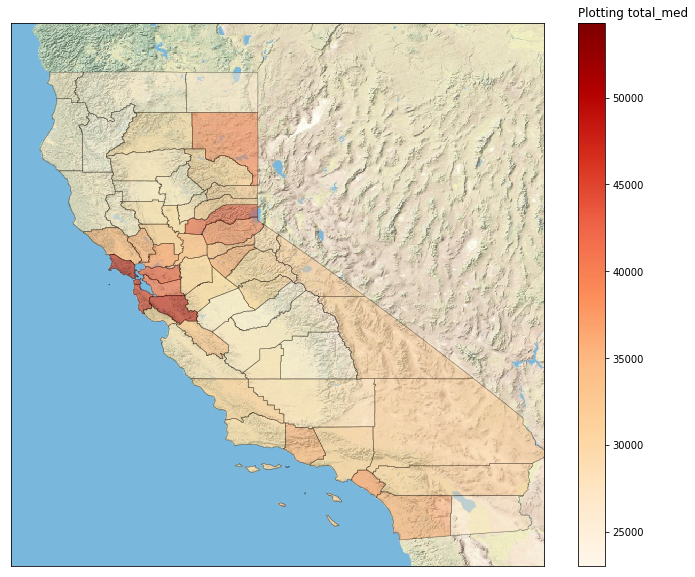

<Figure size 576x576 with 0 Axes>

In [54]:
fig, ax1 = plt.subplots(figsize=(12, 10))
mapbase = plot_map(lonmin,lonmax,latmin,latmax,axis_input=ax1,geodatabase=cal_counties,colorby='total_med')

#### Next, lets fetch some earthquakes and figure out a way of plotting them, and possibly also make a heat map of earthquakes

In [56]:
import obspy as op
from obspy.clients.fdsn import Client
client = Client("IRIS")

In [106]:
cat = client.get_events(starttime=op.UTCDateTime('1970-01-01'), 
    endtime=op.UTCDateTime('2018-10-01'),minlatitude=latmin,maxlatitude=latmax,
    minlongitude=lonmin,maxlongitude=lonmax,minmagnitude=4)

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


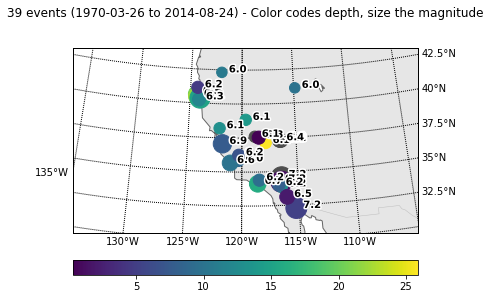

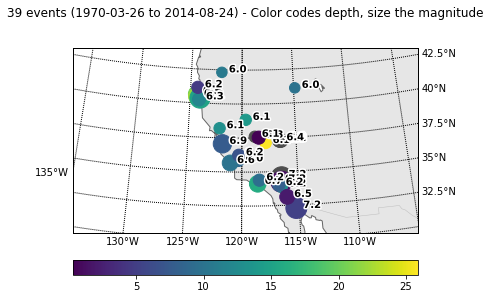

In [66]:
#obspy has some nice plotting tools of its own, useful for quick display
cat.plot(projection='local',show=False)

In [108]:
elats = []
elons = []
emags = []
for event in cat:
    elats.append(float(event.origins[0].latitude))
    elons.append(float(event.origins[0].longitude))
    emags.append(float(event.magnitudes[0].mag))
    
events = np.zeros([len(elats),3])
events[:,0] = elats
events[:,1] = elons
events[:,2] = emags

In [109]:
import folium
from folium import plugins

In [110]:
#We can plot a nice map of earthquakes using Folium 

url_base = 'http://server.arcgisonline.com/ArcGIS/rest/services/'
service = 'NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}'
tileset = url_base + service
m = folium.Map(location=[37.8716, -122.2727], zoom_start=2,\
                control_scale = True, tiles=tileset, attr='USGS style')

# I am using the magnitude as the weight for the heatmap
m.add_child(plugins.HeatMap(data=events, radius = 10))